In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # Транспонируем для удобства оси координат

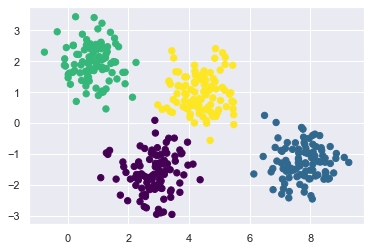

In [3]:
# Выводим данные на график с полученными методом k-средних метками
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [5]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
	labels = kmeans.fit_predict(X)
	# Выводим на рисунок входные данные
	ax = ax or plt.gca()
	ax.axis('equal')
	ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
	# Выводим на рисунок представление модели k-средних
	centers = kmeans.cluster_centers_
	radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
	for c, r in zip(centers, radii):
		ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

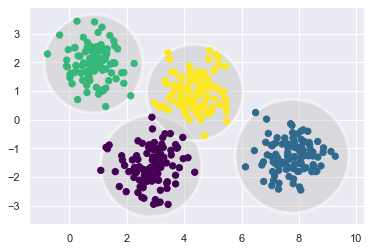

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

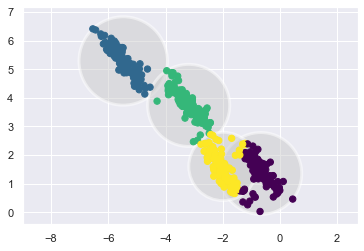

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

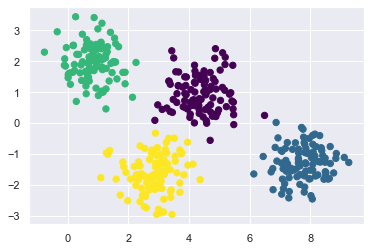

In [9]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [10]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


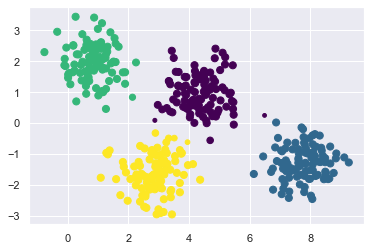

In [11]:
size = 50 * probs.max(1) ** 2 # Возведение в квадрат усиливает влияние различий
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [24]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs): 
	"""Рисует эллипс с заданными расположением и ковариацией""" 
	ax = ax or plt.gca()
	# Преобразуем ковариацию к главным осям координат
	if covariance.shape == (2, 2):
		U, s, Vt = np.linalg.svd(covariance)
		angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
		width, height = 2 * np.sqrt(s)
	else:
		angle = 0
		width, height = 2 * np.sqrt(covariance)
		# Рисуем эллипс
		for nsig in range(1, 4):
			ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


def plot_gmm(gmm, X, label=True, ax=None):
	ax = ax or plt.gca()
	labels = gmm.fit(X).predict(X)
	if label:
		ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
	else:
		ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
		ax.axis('equal')
		w_factor = 0.2 / gmm.weights_.max()
		for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
			draw_ellipse(pos, covar, alpha=w * w_factor)

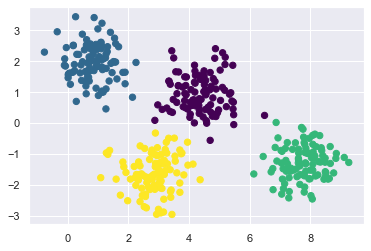

In [25]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

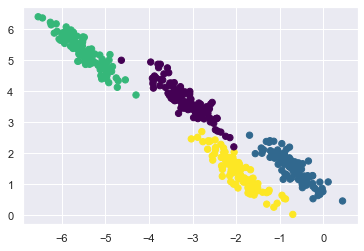

In [26]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

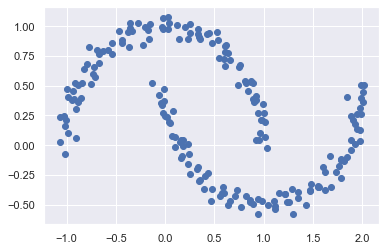

In [27]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

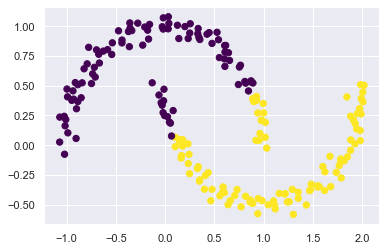

In [28]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

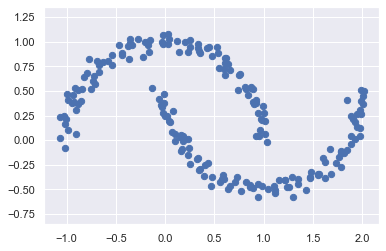

In [29]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

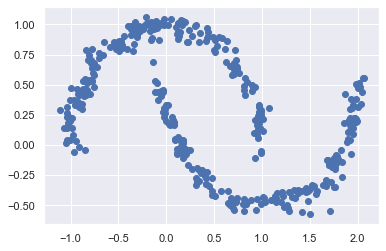

In [34]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

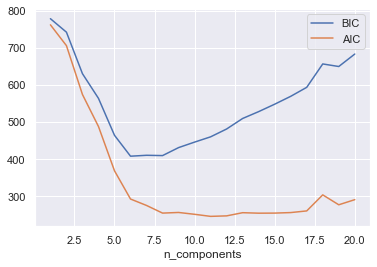

In [35]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [36]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

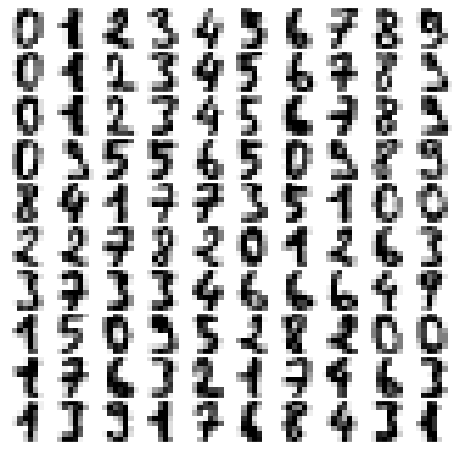

In [37]:
def plot_digits(data):
	fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
	fig.subplots_adjust(hspace=0.05, wspace=0.05)
	for i, axi in enumerate(ax.flat):
		im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
	im.set_clim(0, 16)
plot_digits(digits.data)

In [38]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

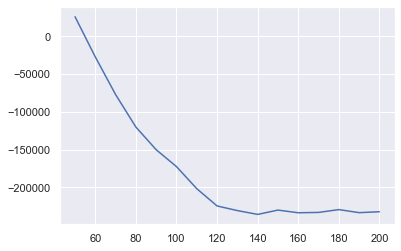

In [39]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [40]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [43]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

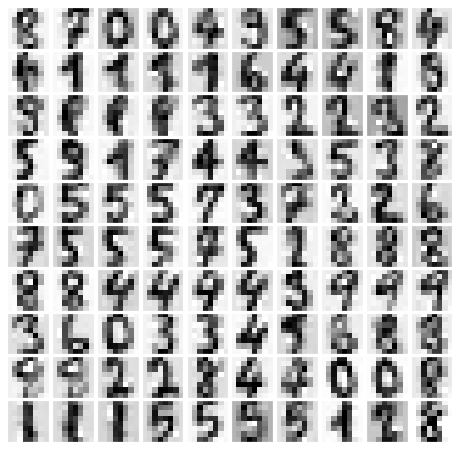

In [44]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)